# 1. Setup

In [1]:
from pqdm.processes import pqdm

from utils import *

# 2. Prepare data

## 2.1. Download LODES data

State codes downloaded from [here](https://www.bls.gov/respondents/mwr/electronic-data-interchange/appendix-d-usps-state-abbreviations-and-fips-codes.htm).

In [2]:
state_list = (pd.read_csv('../data/zones/us/state_codes.csv')
              .sort_values('fips').head(50)).disp()

50 rows x 3 cols; Memory: 0.0 MiB


,name,code,fips
,<object>,<object>,<int64>
0,Alabama,AL,1


In [3]:
def download_lodes(table, state_code, year):
    assert table in ['od', 'rac', 'wac'], table
    root = 'https://lehd.ces.census.gov/data/lodes/LODES8'
    segments = D(S000='total', SE01='low_earn', SE03='high_earn')
    if table == 'od': ## if OD flows
        url = '{0}/{1}/od/{1}_od_main_JT00_{2}.csv.gz'.format(
            root, state_code.lower(), year)
        df = pd.read_csv(url)
        df['src'] = df['h_geocode'].astype(str).str.zfill(15).str[:12]
        df['trg'] = df['w_geocode'].astype(str).str.zfill(15).str[:12]
        df = (df.groupby(['src', 'trg'])[list(segments.keys())].sum()
              .astype(np.int32).rename(columns=segments).reset_index())
    else: ## if RAC or WAC
        dfs = []
        for seg_key, seg_name in segments.items():
            url = (f'{root}/{state_code.lower()}/{table}/',
                   f'{state_code.lower()}_{table}_{seg_key}_JT00_{year}.csv.gz')
            url = '{0}/{1}/{2}/{1}_{2}_{3}_JT00_{4}.csv.gz'.format(
                root, state_code.lower(), table, seg_key, year)
            df = pd.read_csv(url)
            df['geoid'] = df.iloc[:, 0].astype(str).str.zfill(15).str[:12]
            df = df.groupby('geoid')['C000'].sum().rename('jobs').reset_index()
            dfs.append(df.assign(segment=seg_name))
        df = pd.concat(dfs).pivot_table('jobs', 'geoid', 'segment', sort=False)
        df = df.fillna(0).astype(np.int32).reset_index().rename_axis(None, axis=1)
    return df
    
# x = download_lodes('od', 'RI', 2021); x

### 2.1.1. Zonal jobs

In [4]:
def get_node_table(node, year=2021, overwrite=False):
    outpath = Path(f'../data/lehd/{node}_{year}.parquet')
    if outpath.exists() and not overwrite:
        return pd.read_parquet(outpath)
    dfs = []
    for _, r in tqdm(state_list.iterrows(), total=len(state_list)):
        try:
            dfs.append(download_lodes(node, r.code, year))
        except Exception as e:
            print(f'ERROR: {r["name"]} ({node.upper()}): {e}')
    df = pd.concat(dfs).reset_index(drop=1).astype(D(geoid=CAT))
    df.to_parquet(mkfile(outpath))
    return df

rac = get_node_table('rac', overwrite=0).disp() # t=4:08
wac = get_node_table('wac', overwrite=0).disp(0) # t=1:57 (error in AK, AR, MS)

238,182 rows x 4 cols; Memory: 27.4 MiB


,geoid,total,low_earn,high_earn
,<category>,<int32>,<int32>,<int32>
0,010010201001,234,52,106


232,125 rows x 4 cols; Memory: 26.9 MiB


,geoid,total,low_earn,high_earn
,<category>,<int32>,<int32>,<int32>


### 2.1.2. Job OD flows

In [5]:
# # t=13:16 (error in AK, AR, MS)
# year, od = 2021, []
# for _, r in tqdm(state_list.iterrows(), total=len(state_list)):
#     try:
#         od.append(download_lodes('od', r.code, year))
#     except Exception as e:
#         print(f'ERROR: {r["name"]}: {e}')
# od = pd.concat(od).reset_index(drop=1).astype(D(src=CAT, trg=CAT))
# od.to_parquet(U.mkfile(f'../data/lehd/od_{year}.parquet'))

In [6]:
# od = pd.read_parquet('../data/lehd/od_2021.parquet').disp()

## 2.2. Compute accessibility

### 2.2.1. Impedance function

In [7]:
imped_params = (
    pd.read_csv('../data/nhts/fitted-params-power-exponential.csv')
    .query('purpose == "Work" & measure == "Duration" & parameter != "r2"')
    .pivot_table('value', 'mode', 'parameter').reset_index()
    .rename_axis(None, axis=1).assign(mode=lambda df: df['mode'].str.lower())
    .set_index('mode')
).disp(None)

3 rows x 2 cols; Memory: 0.0 MiB


,alpha,beta
mode,<float64>,<float64>
bike,0.008696,1.617997
drive,0.008252,1.49344
walk,0.06405,1.094094


### 2.2.2. Potential accessibility
This only requires total jobs at the destination, not the OD flows

In [8]:
# travel time thresholds (in minutes)
thresholds = (15, 30, 45, 60, 90)

In [9]:
def get_potential_access(level, region, scale, mode, thresh,
                         year=2020, params=imped_params):
    cols = 'region scale mode thresh kind geoid opport'.split()
    try:
        jobs = get_node_table('wac')
        nchar = D(county=5, tract=11, bg=12)[scale]
        jobs['geoid'] = jobs['geoid'].str[:nchar]
        jobs = jobs.groupby('geoid').sum().reset_index()
        jobs = jobs.melt('geoid', var_name='kind', value_name='jobs')
        alpha, beta = params.loc[mode].tolist()
        # read travel time between the zones of given scale by given mode
        tt_file = Path(f'../data/osrm/{level}/{region}/{scale}_{mode}_{year}.parquet')
        tt_cols = D(src_geoid='src', trg_geoid='trg', duration='time')
        tt = pd.read_parquet(tt_file, columns=tt_cols.keys()).rename(columns=tt_cols)
        zones = tt['src'].unique()
        tt = pd.concat([tt, Pdf(D(src=zones, trg=zones, time=0))])
        tt = tt.set_index(['src', 'trg'])['time'] / 60 # travel time in minutes
        t = tt[tt <= thresh] # travel times for filtered OD pairs
        od = np.exp(-alpha * t ** beta).rename('weight').reset_index()
        od = od.merge(jobs, left_on='trg', right_on='geoid')
        od['opport'] = od['jobs'] * od['weight']
        xs = od.groupby(['src', 'kind'])['opport'].sum().reset_index()
        xs = xs[['src', 'kind', 'opport']].rename(columns=D(src='geoid'))
        xs = xs.assign(region=region, scale=scale, mode=mode, thresh=str(thresh))
        xs = xs[cols]
    except Exception:
        xs = Pdf([], columns=cols)
    return xs

# x = get_potential_access('state', '01-alabama', 'tract', 'drive', 30).disp()
x = get_potential_access('msa', '12420-austin', 'bg', 'drive', 30).disp()

3,891 rows x 7 cols; Memory: 1.3 MiB


,region,scale,mode,thresh,kind,geoid,opport
,<object>,<object>,<object>,<object>,<object>,<category>,<float64>
0,12420-austin,bg,drive,30,high_earn,480219501011,1778.182775


In [10]:
def get_potential_access_all(level, year=2020, thresholds=thresholds,
                             njobs=4, overwrite=False):
    outpath = Path(f'../data/access/job_{level}_{year}.parquet')
    if outpath.exists() and not overwrite:
        return pd.read_parquet(outpath)
    files = Path(f'../data/osrm/{level}').glob(f'*/*_{year}.parquet')
    cases = sum([[D(level=level, region=f.parent.stem,
                    scale=f.stem.split('_')[0], mode=f.stem.split('_')[1],
                    thresh=t, year=year) for t in thresholds]
                 for f in files], [])
    np.random.shuffle(cases) # shuffle to hopefully reduce parallel load
    dfs = pqdm(cases, get_potential_access, n_jobs=njobs, argument_type='kwargs')
    cat_cols = 'region scale mode thresh kind geoid'.split()
    access = (pd.concat(dfs).astype(D(opport=np.int32))
              .sort_values(cat_cols).reset_index(drop=1)
              .astype({x: CAT for x in cat_cols})[cat_cols + ['opport']])
    access.to_parquet(mkfile(outpath))
    return access

# xs_st = get_potential_access_all('state', overwrite=0, njobs=16).disp() # t=1:57
xs_msa = get_potential_access_all('msa', overwrite=1, njobs=12).disp() # t=13:18
# x = get_potential_access_all('msa', overwrite=1, njobs=4); x # t=13:18

QUEUEING TASKS | :   0%|          | 0/2100 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/2100 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/2100 [00:00<?, ?it/s]

7,255,665 rows x 7 cols; Memory: 104.6 MiB


,region,scale,mode,thresh,kind,geoid,opport
,<category>,<category>,<category>,<category>,<category>,<category>,<int32>
0,12060-atlanta,bg,bike,15,high_earn,130131801031,200


# 3. Analyze

In [25]:
xsbg = xs.query('scale=="bg"').astype(D(geoid=str)).disp()

64,440 rows x 7 cols; Memory: 5.3 MiB


,region,scale,mode,thresh,kind,geoid,opport
,<category>,<category>,<category>,<category>,<category>,<object>,<int32>
0,26900-indianapolis,bg,bike,15,high_earn,180118101001,138


In [26]:
xs2 = indy[['geoid', 'geometry']].merge(xsbg, on='geoid').disp()

64,440 rows x 8 cols; Memory: 5.3 MiB; CRS: EPSG:4326


,geoid,geometry,region,scale,mode,thresh,kind,opport
,<object>,<geometry>,<category>,<category>,<category>,<category>,<category>,<int32>
0,180118101001,"POLYGON ((-86.58171 40.08374, -86.5817 40.0840...",26900-indianapolis,bg,bike,15,high_earn,138


<Axes: >

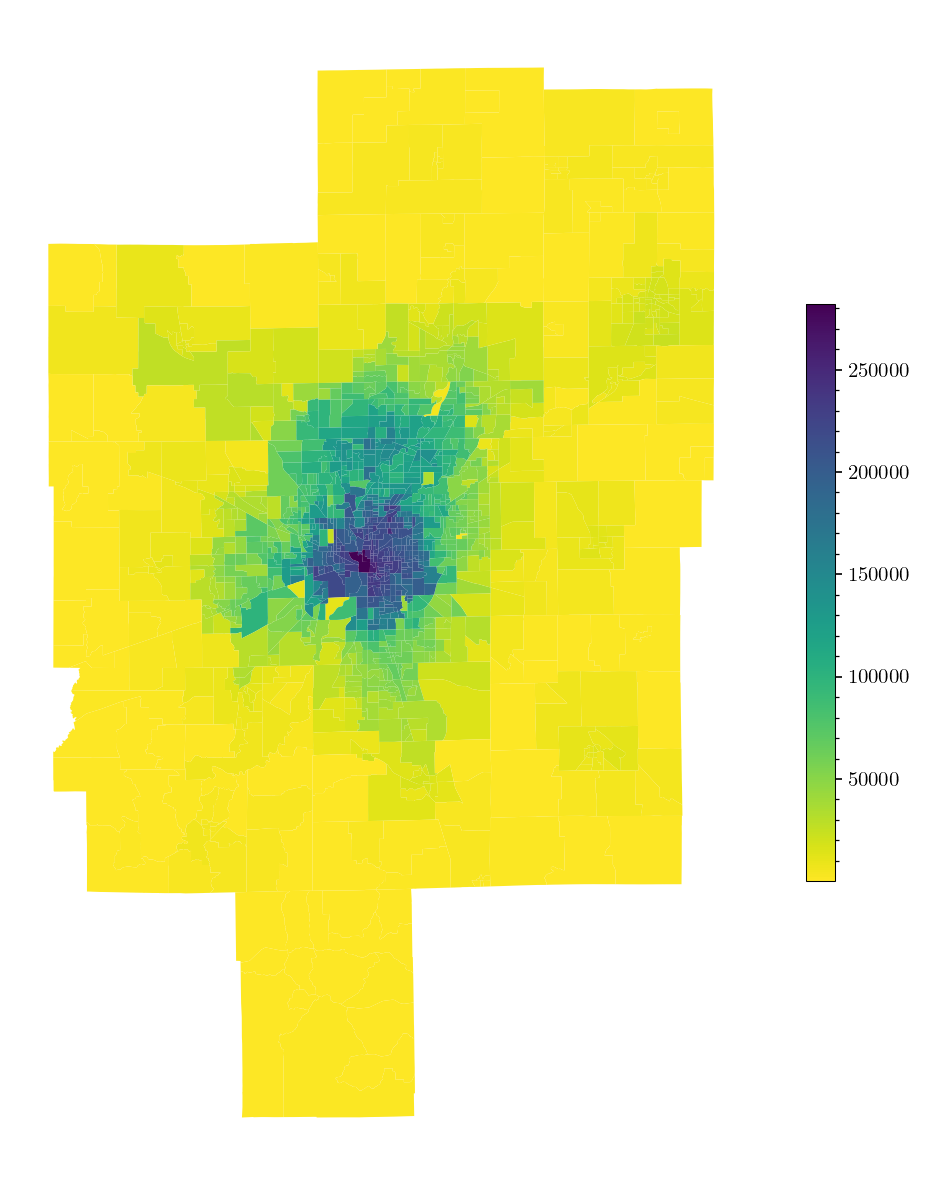

In [31]:
ax = pplot(size=(10, 10), dpi=150, axoff=1)
xs2.query('mode=="drive" & thresh=="15" & kind=="total"').plot(ax=ax, column='opport', cmap='viridis_r', legend=True, legend_kwds=D(shrink=0.5))

<Axes: >

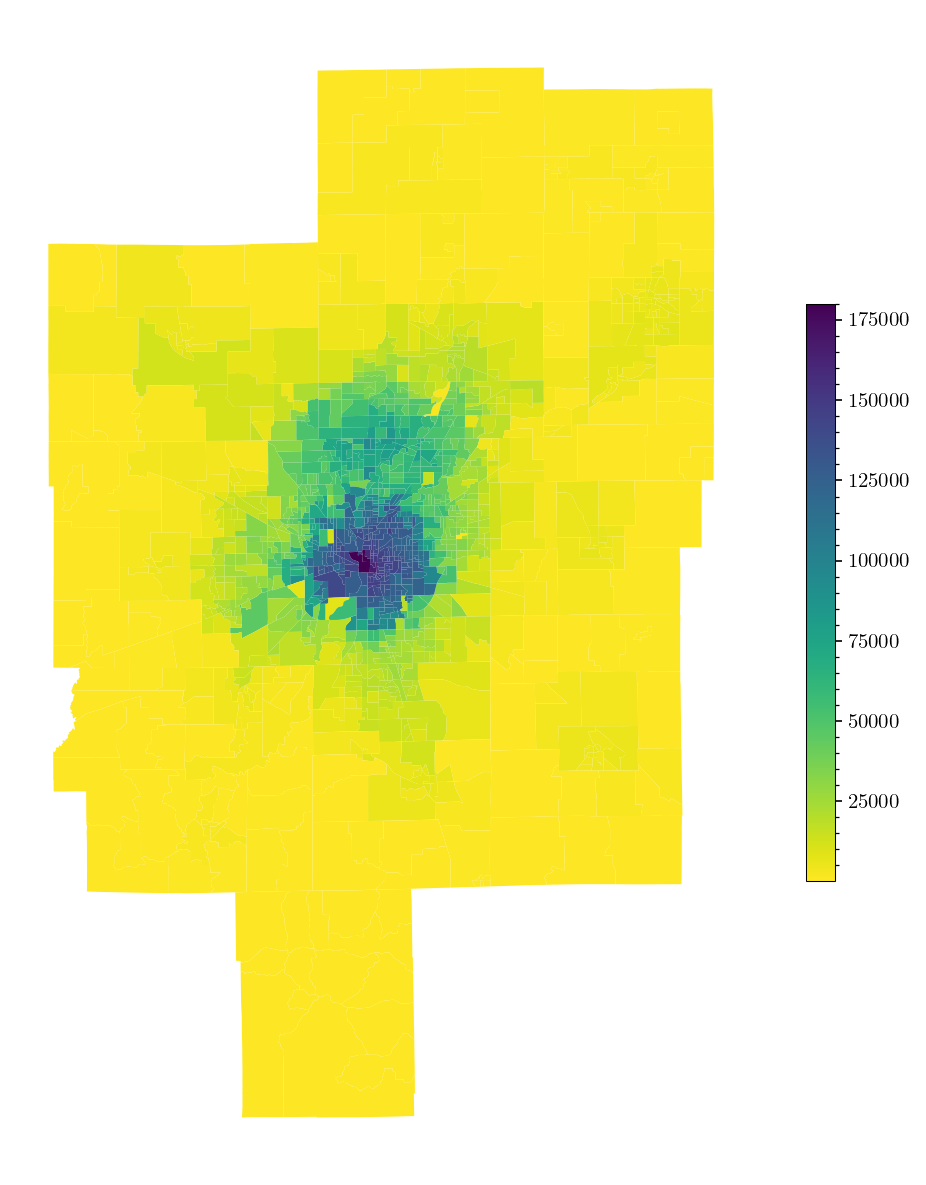

In [36]:
ax = pplot(size=(10, 10), dpi=150, axoff=1)
xs2.query('mode=="drive" & thresh=="15" & kind=="high_earn"').plot(ax=ax, column='opport', cmap='viridis_r', legend=True, legend_kwds=D(shrink=0.5))